In [133]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [244]:
import pandas as pd
def binbinplot(y1, y2, bins = 100, 
               ax = None, title = None,
               xlabel=None, ylabel=None):
    df = pd.DataFrame({'y1': y1, 'y2': y2})
    df['bin'] = pd.qcut(df['y1'], bins)
    bin_y1 = df.groupby('bin', observed=True)['y1'].mean()
    bin_y2 = df.groupby('bin', observed=True)['y2'].mean()

    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)


    ax.scatter(bin_y1, bin_y2, alpha = 0.8)

In [245]:
def generate_data(n_samples, target_cm, random_state, vis_cm = False):
    rng = np.random.default_rng(random_state)
    n_features, _ = target_cm.shape

    # use the cholesky decomposition to get target_cm = L @ L.T
    L = np.linalg.cholesky(target_cm)


    # generate the data using L to produce the desired correlations
    Z = rng.normal(size=(n_samples, n_features))
    data = Z @ L.T

    empirical_cm = np.corrcoef(data, rowvar=False)
    if vis_cm:
        sns.heatmap(empirical_cm, annot=True)

    print(f"data std dev:", data.std(axis = 0))

    return data

In [246]:
def generate_cm(feature_feature_corr, feature_target_corr):
    R = np.full((11, 11), feature_feature_corr)
    np.fill_diagonal(R, 1.0)
    R[-1, :-1] = feature_target_corr
    R[:-1, -1] = feature_target_corr

    return R

In [281]:
def run_fit(data, model, suppress_output = False):
    features = data[:, :10]
    target = data[:, 10]

    num_train = int(0.5 * len(features))
    train_X, train_y = features[:num_train], target[:num_train]
    test_X, test_y = features[num_train:], target[num_train:]

    
    model.fit(train_X, train_y)
    if not suppress_output:
        print(f"model.coef_ = {model.coef_}")

    train_y_pred = model.predict(train_X)
    train_R2 = model.score(train_X, train_y)

    test_y_pred = model.predict(test_X)
    test_R2 = model.score(test_X, test_y)


    if not suppress_output:
        fig, axs = plt.subplots(1,1, figsize=(8,6))
        axs.grid()
        axs.set_title(f'Train R2: {train_R2:.4f}, Test R2: {test_R2:.4f}')
        binbinplot(train_y_pred, 
                train_y,
                ax = axs,
                bins = 20,
                xlabel = 'y_pred', ylabel = 'y_true')
        binbinplot(test_y_pred, 
                test_y,
                ax = axs,
                bins = 20,
                xlabel = 'y_pred', ylabel = 'y_true')
        
        axs.legend(['train', 'test'])
    
    return train_R2, test_R2

In [283]:
R = generate_cm(0.05, 0.1)
modify = [(0, 10, 0.01), (1, 10, 0.01), 
          (0, 1, 0.9)]

for i in range(0, 6, 2):
    j = i + 1
    modify.append((i, 10, 0.01))
    modify.append((j, 10, 0.01))
    modify.append((i, j, 0.9))

for i, j, corr in modify:
    R[i, j] = R[j, i] = corr

# data = generate_data(100, R, 0, vis_cm=True)
data = generate_data(100, R, 0)


basic_ols_train = []
basic_ols_test = []
nonnegative_ols_train = []
nonnegative_ols_test = []
for i in range(100):
    model = LinearRegression(fit_intercept = False)
    train_r2, test_r2 = run_fit(data, model, suppress_output=True)
    basic_ols_train.append(train_r2)
    basic_ols_test.append(test_r2)

    model = LinearRegression(fit_intercept = False, positive=True)
    train_r2, test_r2 = run_fit(data, model, suppress_output=True)
    nonnegative_ols_train.append(train_r2)
    nonnegative_ols_test.append(test_r2)

data std dev: [0.97294611 0.95706464 1.00621503 1.00540937 0.86167401 0.95336207
 1.08328342 0.97122062 0.86490458 1.10226815 0.9065881 ]


In [284]:
mean_basic_ols_trainR2 = np.mean(basic_ols_train)
mean_basic_ols_testR2 = np.mean(basic_ols_test)
mean_nonnegative_ols_trainR2 = np.mean(nonnegative_ols_train)
mean_nonnegative_ols_testR2 = np.mean(nonnegative_ols_test)

print(f"mean basic train = {mean_basic_ols_trainR2:.4f}, test = {mean_basic_ols_testR2:.4f} ")
print(f"mean nonnegative train = {mean_nonnegative_ols_trainR2:.4f}, test = {mean_nonnegative_ols_testR2:.4f} ")

mean basic train = 0.1711, test = -0.0939 
mean nonnegative train = 0.1049, test = 0.0850 


data std dev: [0.97294611 0.92001084 1.0077727  1.04581739 0.87274427 1.04742683
 1.09079978 0.97570129 0.86699314 1.10366331 0.91099224]
model.coef_ = [ 0.08035513 -0.13240561  0.28708718 -0.07711969  0.13183961 -0.03225352
  0.03152573  0.14468608  0.1823427   0.1367175 ]


(0.18135639853161734, -0.009730720017687489)

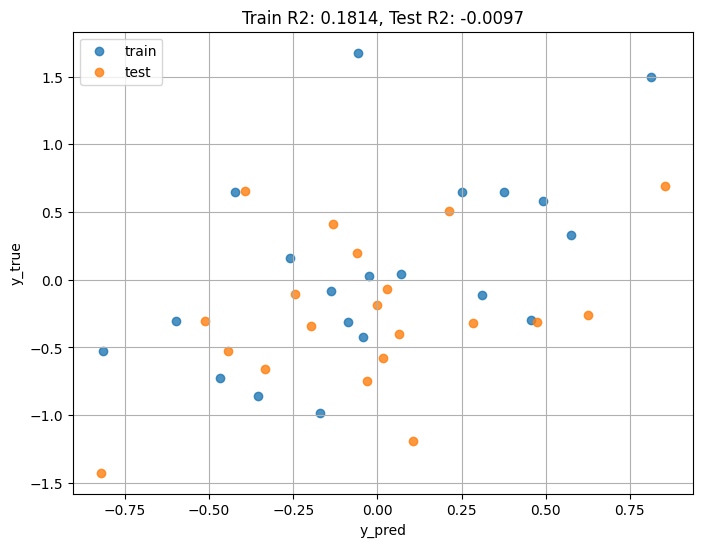

In [285]:
"""
In case you wanted to see what it looks like without such large intercorrelations
"""
R = generate_cm(0.05, 0.1)
modify = []
for i, j, corr in modify:
    R[i, j] = R[j, i] = corr

data = generate_data(100, R, 0, vis_cm = False)
model = LinearRegression(fit_intercept = False)
run_fit(data, model, suppress_output=False)